<h1>Here we calculate the orbital evolution of binaries as one or both of the stars evolve off of the main sequence. This file is for step 1, when only the more massive star evolves.</h1>
<p>Written by Nadia Zakamska, June 2024.
<p>The stellar population synthesis model is set up in a separate file (constant SFR over 12 Gyr, masses from Kroupa, MS lifetime).  
<p>Here we incorporate: time-dependent mass loss and kick velocity, 
<p>total fractional mass loss given by Cummings, 
<p>and let's see how much this takes and if we can try a couple of different values of vasym.
<p>Different regimes of orbital evolution are differentiated by $\eta=\tau_{\rm orbital}/\tau_{\rm evolution}$. If $\eta\ll 1$, then we use the orbit-averaging (Hamiltonian) approximation. If $\eta\sim 1$ within an order of mag or so, we use direct integration. If $\eta\gg $, we use the kick approximation. The exact cutoff values of $\eta$ were obtained by experimenting with different cutoffs in a different notebook are ended up quite conservative, in that we directly integrate the types of systems where the answer is at all ambiguous. 

In [1]:
# library imports
import numpy as np
from matplotlib import pyplot as plt
import sys
from astropy.table import Table
from astropy.io import fits
from scipy.integrate import solve_ivp
from scipy import interpolate
import time
# this is the library of helper functions provided separately, should be in the same folder as the notebook
import orbital

###Plot formatting commands
plt.rc('figure', figsize=(6,5)) 
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands

In [2]:
# let's read them in:
hdul=fits.open('public_mybinaries_setup.fits')
temp = Table(hdul[1].data) # assuming the first extension is a table
hdul.close()
nbinaries=len(temp)
print(nbinaries)
# So... I am afraid 1e7 is too many for us to integrate. Let's take the first 1e6.
nbinaries=1000000
mybinaries=temp[0:nbinaries]
print(len(mybinaries))
# OK, let's go with this. 


10000000
1000000


In [3]:
ind0=(mybinaries['class']==0) # These are MS-WD binaries
ind1=(mybinaries['class']==1) # These are MS-MS binaries
ind2=(mybinaries['class']==2) # These are WD-WD binaries
ind02=((mybinaries['class']==0) | (mybinaries['class']==2)) # These are all the binaries in which anything evolved
# OK, let's split the table into three:
mybin0=Table(mybinaries[ind0], copy=True)
mybin1=Table(mybinaries[ind1], copy=True)
mybin2=Table(mybinaries[ind2], copy=True)
mybin02=Table(mybinaries[ind02], copy=True)
# let's get this straight - how many of each class do we have?
print(len(mybin0),len(mybin1),len(mybin2), len(mybin02))

280763 685080 34157 314920


<h2>Some important model parameters of the model are set here</h2>

In [4]:
# code values = physical values * these units
vunit=1./29.78
aunit=1./(29.78*2*np.pi)
tunit=2*np.pi

In [5]:
# these are the overall evolutionary parameters
tintegrate=3e5 # this is the evolutionary time in years
tfinal=tintegrate*tunit # this is in code units
vasym=2.0 # in km/sec

In [6]:
# eta cutoff values determine which regime of integration we are in. 
eta_ham=0.03
eta_impact=10.

<h2>Let's deal with the evolution of the more massive star first</h2>

In [7]:
# compute the eta parameter
def eta_parameter(t0, m, a):
    # eta is equal to the ratio of the orbital period to the evolutionary timescale (mass-loss timescale)
    return(orbital.per(m,a)/t0)

In [8]:
mybin02['eta_out']=eta_parameter(tintegrate,mybin02['fm1']+mybin02['m2'],
                                mybin02['sma']*(mybin02['m1']+mybin02['m2'])/(mybin02['fm1']+mybin02['m2']))
mybin02['eta_in']=eta_parameter(tintegrate,mybin02['m1']+mybin02['m2'],mybin02['sma'])

In [9]:
# The binary should satisfy impact and especially secular regimes both before and after evolution
ind_imp=((mybin02['eta_out']>eta_impact) & (mybin02['eta_in']>eta_impact))
ind_ham=((mybin02['eta_out']<eta_ham) & (mybin02['eta_in']<eta_ham))
ind_dir=((~ind_imp) & (~ind_ham))

In [10]:
print('impulsive: ', len(mybin02[ind_imp]))
print('Hamiltonian: ', len(mybin02[ind_ham]))
print('direct: ', len(mybin02[ind_dir]))
print('total: ', len(mybin02))

impulsive:  10392
Hamiltonian:  213365
direct:  91163
total:  314920


In [11]:
mybin0[0:5]

m1,m2,bday,sma,ecc_slope,ecc,death1,death2,class,omega,asclong,mean_anomaly,inc,omega_step2,asclong_step2,mean_step2,inc_step2,fm1,fm2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4.379685166175097,0.7791688276124161,1.3945381818851592,7.374446871618838,0.0,0.6547398003687833,1.5126306264050577,22.537605624908156,0.0,3.9249221672379417,0.018333921781242393,1.755937747083724,2.593252734703741,0.6432803286340628,1.8718174335275393,0.8379650844065315,1.9691605536326684,0.9396263127807354,0.5213859841637782
1.6996488519607558,0.7195830495413886,9.730845908371451,574.2315928940956,1.077371145242925,0.9337659703094744,11.349061088090188,37.59478257565382,0.0,1.8183624724015608,6.084356814814093,4.808019469767791,0.9869054475517569,2.1072782464172617,4.8651938103826815,1.966292808027665,0.8112907259776045,0.6249719081568604,0.4815137659220329
1.6921771109659463,0.3619608012101761,3.2050221144090654,1.901757807819526,0.0,0.2555789981067923,4.845449004279139,318.84861682484694,0.0,0.6395028876909552,3.0660300754851693,4.23950478343326,2.235448541367307,2.3805098169478196,3.9400811859650053,4.961561495825968,0.40079192054826057,0.6243741688772757,0.24220846866521906
3.9058041868301263,0.6038411053420013,1.818838341615534,534.3467668699335,1.0585070438642243,0.8423865845266403,1.9752108170066611,53.30982623696581,0.0,5.146245847077379,5.465071315783849,0.576970362334685,2.296602238124462,2.7241098383403997,2.4289289225721986,5.288229105330632,1.9017796418808937,0.8889210479908235,0.4040642769963223
1.3494406559789431,0.9262736390107047,3.272590503825831,50.37348828409768,0.0,0.1253693253282362,6.627822725288479,14.957322709034383,0.0,3.069433606244594,4.907596821319157,5.166681234296408,0.5281580429217205,1.7181878605019367,0.17105348043510457,0.03899063987687326,1.5005239323151283,0.5969552524783155,0.5631018911208564


<h2>Dealing with impulsive sources first</h2>

In [12]:
# create final states for SMAs and eccentricities assuming just adiabatic evolution with no kick.
# OK, apparently this kind of copying is a kosher thing to do, and if I then change an individual value of fecc
# it doesn't come to bite ecc in the [bum]
# I don't think I have to keep track of the inclination... For the objects with two stages of evolution, 
# the second inclination is defined relative to the kick direction of the second star, which is randomized. 
mybin02['fecc']=mybin02['ecc']
mybin02['fsma']=mybin02['sma']*(mybin02['m1']+mybin02['m2'])/(mybin02['fm1']+mybin02['m2'])
# this is in km/sec
mybin02['vkick']=vasym*np.log(mybin02['m1']/mybin02['fm1'])

In [13]:
# ind_imp: 
# let's now deal with the impulse approximation category
orbit=Table(mybin02[ind_imp],copy=True)
u=np.transpose([np.zeros(len(orbit)),np.zeros(len(orbit)),-np.array(orbit['vkick'])*vunit])
# carefully take into account which star is losing mass: it's m1
new_orbit=Table(orbital.one_kick_loss(orbit['m2'],orbit['m1'],orbit['m1']-orbit['fm1'],u,orbit))

In [14]:
new_orbit[0:5]

sma,ecc,inc,asclong,omega,mean_anomaly
float64,float64,float64,float64,float64,float64
-451.5871445926296,74.75686085176962,1.5452997282128051,2.8970116229433716,6.190763196950676,29.362724459941052
-148.52354926723302,378.9094021787572,1.5784627760209915,4.754017214609059,6.244327154582283,154.5997568903767
-119.09039118002566,82.98080345334836,1.5524853871530995,1.212817737487306,6.0777543994877465,47.19612684658625
-326.4058882869678,102.45346573556968,1.4742158735718818,2.3134469414946786,6.219373333280039,-80.37388777049031
-179.9406707906279,1057.9680379848835,1.5681197211861775,1.767783304130833,0.024549122307383067,-578.128378822869


In [15]:
ind_retained=(new_orbit['sma']>0)
print(len(new_orbit[ind_retained]))
# almost all are disrupted.  
# Let's populate the relevant columns in the main table:
mybin02['fsma'][ind_imp]=np.array(new_orbit['sma'])
mybin02['fecc'][ind_imp]=np.array(new_orbit['ecc'])
# OK, done with the impulsive part! 

1


In [16]:
(mybin02[ind_imp])[0:5]

m1,m2,bday,sma,ecc_slope,ecc,death1,death2,class,omega,asclong,mean_anomaly,inc,omega_step2,asclong_step2,mean_step2,inc_step2,fm1,fm2,eta_out,eta_in,fecc,fsma,vkick
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.2347092644451436,0.32490487616845076,2.3624940480497103,32655.7815917128,1.3638736919540189,0.907714779148113,6.840239720271718,464.69188737242484,0.0,0.8529560923652484,5.831361285554832,0.7467303630950707,1.1499096232553563,1.8957694344937142,4.163642789106044,2.6980347272479284,0.7880564054947464,0.5877767411556115,0.217412250872238,46.093346924037135,15.78492499180574,74.75686085176962,-451.5871445926296,1.4844872481161488
3.5596031283330207,0.6233534432567532,0.18403864565820394,38665.55684938165,1.3648126035637111,0.6586668489945472,0.38188709181002456,46.22574977640554,0.0,2.925353168341326,4.689682009566018,2.3252790526347695,1.7132653147949268,3.70486251419959,1.1503285472098723,1.8845982004799962,1.177493795903634,0.8496457849982748,0.41712108721060337,100.14225787700427,12.418115828735464,378.9094021787572,-148.52354926723302,2.865169595453516
3.7649590032331295,0.56855194935068,6.510832365605617,39701.830381196065,1.364945998774361,0.769373976642912,6.682321125611768,70.1800383278664,0.0,4.591100465124026,1.263729383344547,0.09240893648260419,1.4955761242418493,3.087472707373591,5.276749122562554,0.696645730138349,1.344694805143451,0.8738506133459448,0.3804503044209249,114.58127539921033,12.694243527608023,82.98080345334836,-119.09039118002566,2.92116562631561
1.396701823118869,0.4980993427114328,7.563741858049925,72932.51687801316,1.367224470490442,0.5800333058493856,10.567395006532065,109.24371405976676,0.0,0.12516855948183953,0.3782792180097513,0.5894684570956787,0.9047924670226686,4.813454230304701,3.2014916752178775,1.362003394572277,1.0258716964700134,0.6007361458495095,0.33330647583365036,142.12579036610578,47.79813600304083,102.45346573556968,-326.4058882869678,1.687426165377609
2.880118825616274,0.8291895678926613,8.332356482061325,136523.23479882875,1.3685044058217328,0.8976433876624147,8.679407577426167,25.39298674094077,0.0,3.5736572746090207,1.664271851395341,4.484241086554019,1.4193420957181087,1.0159001309504234,4.466494120003459,2.0124244840176746,1.8114428782248488,0.7225822203902432,0.5548576939850411,499.92464265718036,87.49321278788398,1057.9680379848835,-179.9406707906279,2.7655112356268865


<h2>Dealing with the purely hamiltonian sources</h2>

In [17]:
# let's deal with the hamiltonian sources
ham=Table(mybin02[ind_ham], copy=True)
ham[9008] # this is the one which doesn't integrate, even after the pathological initial conditions are tweaked

m1,m2,bday,sma,ecc_slope,ecc,death1,death2,class,omega,asclong,mean_anomaly,inc,omega_step2,asclong_step2,mean_step2,inc_step2,fm1,fm2,eta_out,eta_in,fecc,fsma,vkick
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.1646033229565917,0.4605573188422174,11.109844380937393,25.211702325846748,0.0,0.21003620820507696,11.890131855558261,145.37896132023334,0.0,3.143758243842876,1.1815041219063542,2.8904088558770034,1.9437939143499832,0.035696666567838466,4.480605231335926,0.7065613933578001,2.5222692691123174,0.6621682658365273,0.3081849817891175,0.0014269239399840297,0.0002609974681809831,0.21003620820507696,58.950085008972515,2.368945398712751


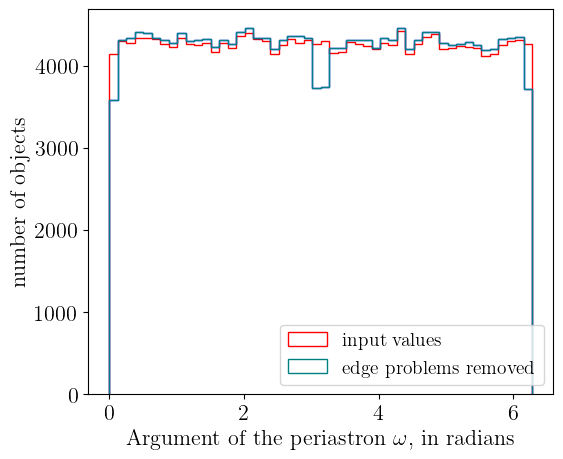

In [18]:
# first, let's avoid the pathological initial conditions omega=0, pi, 2pi and inc=0, pi/2, pi.
tol=1.*np.pi/180. 
new_omega=np.array(ham['omega'])
ind1=(new_omega<=np.pi)
new_omega[ind1]=tol+new_omega[ind1]*(np.pi-2*tol)/np.pi
ind2=(new_omega>np.pi)
new_omega[ind2]=(np.pi+tol)+(new_omega[ind2]-np.pi)*(np.pi-2*tol)/np.pi
fig=plt.figure()
n_bins=50
(n, bins, patches)=plt.hist(np.array(ham['omega']), n_bins, histtype='step', stacked=True, fill=False, color='red', label='input values')
plt.hist(new_omega, bins, histtype='step', stacked=True, fill=False, color='blue')
ham['omega']=np.copy(new_omega)
plt.hist(np.array(ham['omega']), bins, histtype='step', stacked=True, fill=False, color='teal', label='edge problems removed')
plt.xlabel(r'Argument of the periastron $\omega$, in radians')
plt.ylabel(r'number of objects')
plt.legend(loc='lower right')
plt.show()


In [19]:
ham[9008]

m1,m2,bday,sma,ecc_slope,ecc,death1,death2,class,omega,asclong,mean_anomaly,inc,omega_step2,asclong_step2,mean_step2,inc_step2,fm1,fm2,eta_out,eta_in,fecc,fsma,vkick
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.1646033229565917,0.4605573188422174,11.109844380937393,25.211702325846748,0.0,0.21003620820507696,11.890131855558261,145.37896132023334,0.0,3.161187474248896,1.1815041219063542,2.8904088558770034,1.9437939143499832,0.035696666567838466,4.480605231335926,0.7065613933578001,2.5222692691123174,0.6621682658365273,0.3081849817891175,0.0014269239399840297,0.0002609974681809831,0.21003620820507696,58.950085008972515,2.368945398712751


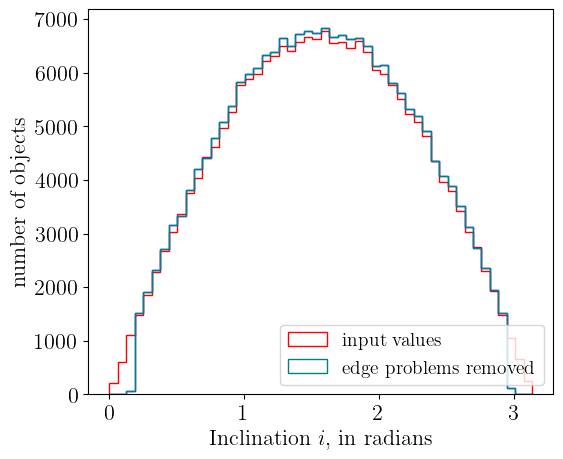

In [20]:
# same for the inclination, although it's probably not necessary?.. It is because 
# Jzin depends on the inclination.
xx=np.cos(ham['inc'])
ind1=(xx>=0.)
xx[ind1]=tol**2+xx[ind1]*(1.-tol-tol**2)
ind2=(xx<0.)
xx[ind2]=-tol**2+xx[ind2]*(1.-tol-tol**2)
fig=plt.figure()
(n, bins, patches)=plt.hist(np.array(ham['inc']), n_bins, histtype='step', stacked=True, fill=False, color='red', label='input values')
plt.hist(np.arccos(xx), bins, histtype='step', stacked=True, fill=False, color='blue')
ham['inc']=np.copy(np.arccos(xx))
plt.hist(np.array(ham['inc']), bins, histtype='step', stacked=True, fill=False, color='teal', label='edge problems removed')
plt.xlabel(r'Inclination $i$, in radians')
plt.ylabel(r'number of objects')
plt.legend(loc='lower right')
plt.show()

We want to make sure to get many integration steps over each loop in the $\omega-J$ plane. The characteristic timescale for the loop is $$t_{\rm Hamiltonian}=\frac{\sqrt{Gm}}{\dot{v}_k\sqrt{a}}.$$ In code units $G=1$. 

In [32]:
myfile=open('hamiltonian_errors.txt','w')
myfile.write('')
myfile.close()
myfile=open('hamiltonian_errors.txt','a')

t0 = time.time()
for i, obj in enumerate(ham):
    Lin=np.sqrt((obj['m1']+obj['m2'])*obj['sma'])
    Jin=Lin*np.sqrt(1-obj['ecc']**2)
    Jzin=Jin*np.cos(obj['inc'])
    # the min number of steps in the Hamiltonian integration: 
    minnum=10000
    deltam=obj['m1']-obj['fm1']
    def tm(t, tfinal=tfinal):
    # this is the total mass of the binary
    # linearly declining to the final value, time is in code units
        return(obj['m1']+obj['m2']-deltam*t/tfinal)
    def ak(t, tfinal=tfinal):
    # this is the recoil acceleration, calculated just for the star losing the mass
    # the time is in the code units and the acceleration is in the code units
        return(vasym*vunit*deltam/(obj['m1']*tfinal-deltam*t))
    # this makes sure that each oscillation in the omega-J plane is resolved by at least minnum number of elements
    deltat_code=np.sqrt(tm(tfinal)/obj['sma'])/ak(tfinal)/minnum
    nsteps=max(minnum, int(tfinal/deltat_code))
    t_eval=np.linspace(0, tfinal, nsteps)
    def rhs(t, v): 
        tol=1.e-14
        par1=max(tol,1-v[0]**2/Lin**2)
        par2=max(tol,1-Jzin**2/v[0]**2)
        return [-ak(t)*np.cos(v[1])*1.5*np.sqrt(par1)*Lin**2/tm(t)*np.sqrt(par2),
           ak(t)*1.5*Lin**2*np.sin(v[1])*(Jzin**2/v[0]**3-v[0]/Lin**2)/(tm(t)*np.sqrt(par1)*np.sqrt(par2))]
    res = solve_ivp(rhs, (0, tfinal), [Jin, obj['omega']], t_eval=t_eval)
#    ham['finc'][i]=np.arccos(Jzin/res.y[0])[nsteps-1]
    if (1-res.y[0][nsteps-1]**2/Lin**2<0): 
        myfile.write(str(i))
        myfile.write(str(obj))
        myfile.write('\n')
    ham['fecc'][i]=np.sqrt(1-res.y[0][nsteps-1]**2/Lin**2)
t1 = time.time()
print('execution time, sec ', t1-t0)
myfile.close()

/var/folders/zc/yg9jy0w136g3bl0300dyfbmc0000gn/T/ipykernel_8597/3525800917.py:38: RuntimeWarning: invalid value encountered in sqrt
  ham['fecc'][i]=np.sqrt(1-res.y[0][nsteps-1]**2/Lin**2)


execution time, sec  178.76881575584412


In [33]:
# OK, a few objects are still not calculating correctly. The complete list in the table ham is saved 
# in hamiltonian_errors.txt. It does look like they all have problematic omega 
# with the exception of 89326, which seems like its parameters are ok... 
is_nan=np.isnan(ham['fecc'])
print(sum(is_nan), len(ham))
# so this is 25 objects... 

25 213365


In [24]:
mybin02['fecc'][ind_ham]=np.copy(ham['fecc'])
# the fsma is just the adiabatic expansion, so it's already done! 

-0.0008605612858973988


/var/folders/zc/yg9jy0w136g3bl0300dyfbmc0000gn/T/ipykernel_8597/1426365526.py:32: RuntimeWarning: invalid value encountered in sqrt
  ham_ecc=np.sqrt(1-res.y[0]**2/Lin**2)


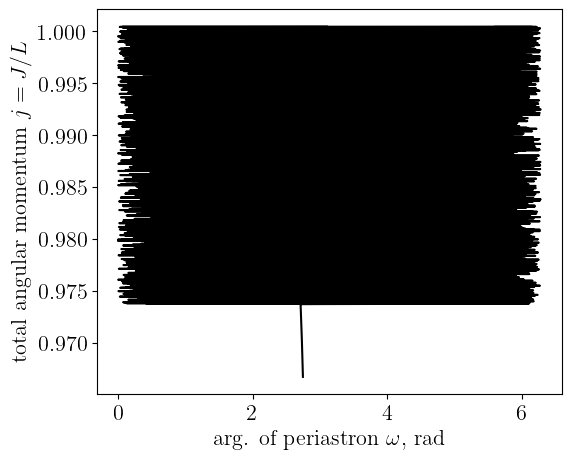

In [36]:
def debugging(): 
    obj=ham[9008]
    obj=ham[89326] #OK, I have no idea why this one is on the problem list... 
    Lin=np.sqrt((obj['m1']+obj['m2'])*obj['sma'])
    Jin=Lin*np.sqrt(1-obj['ecc']**2)
    Jzin=Jin*np.cos(obj['inc'])
    # the min number of steps in the Hamiltonian integration: 
    minnum=10000
    deltam=obj['m1']-obj['fm1']
    def tm(t, tfinal=tfinal):
    # this is the total mass of the binary
    # linearly declining to the final value, time is in code units
        return(obj['m1']+obj['m2']-deltam*t/tfinal)
    def ak(t, tfinal=tfinal):
    # this is the recoil acceleration, calculated just for the star losing the mass
    # the time is in the code units and the acceleration is in the code units
    #    return(vasym*vunit/tfinal)
        return(vasym*vunit*deltam/(obj['m1']*tfinal-deltam*t))
    # this makes sure that each oscillation in the omega-J plane is resolved by at least minnum number of elements
    deltat_code=np.sqrt(tm(tfinal)/obj['sma'])/ak(tfinal)/minnum
    nsteps=max(minnum, int(tfinal/deltat_code))
    t_eval=np.linspace(0, tfinal, nsteps)
    def rhs(t, v): 
        tol=1.e-14
        par1=max(tol,1-v[0]**2/Lin**2)
        par2=max(tol,1-Jzin**2/v[0]**2)
        return [-ak(t)*np.cos(v[1])*1.5*np.sqrt(par1)*Lin**2/tm(t)*np.sqrt(par2),
           ak(t)*1.5*Lin**2*np.sin(v[1])*(Jzin**2/v[0]**3-v[0]/Lin**2)/(tm(t)*np.sqrt(par1)*np.sqrt(par2))]
    res = solve_ivp(rhs, (0, tfinal), [Jin, obj['omega']], t_eval=t_eval)
    print(1-res.y[0][nsteps-1]**2/Lin**2)
    ham_inc=np.arccos(Jzin/res.y[0])
    ham_ecc=np.sqrt(1-res.y[0]**2/Lin**2)
    ham_J=res.y[0]
    ham_omega=res.y[1] % (2*np.pi)
    fig=plt.figure()
    plt.plot(ham_omega,ham_J/Lin,color='black')
    plt.xlabel(r'arg. of periastron $\omega$, rad')
    plt.ylabel(r'total angular momentum $j=J/L$')
    #plt.ylim((0.999,1.))
    #plt.title(r'Surfaces of const hamiltonian, $j_z=J_z/L=$%0.2f' % (jz))
    plt.show()
debugging()
# If I put even a factor of 0.5 in the acceleration, then this problem doesn't arise. 
# It's also interesting that it's on the low eccentricity end... so we seem to have high domega/dt and low
# dJ/dt... 

<h2>The final step is the direct integration</h2>

In [38]:
# Hm. OK. It sounds like the final step is direct integration. We have settled for leapfrog, let's go with that. 
direct=Table(mybin02[ind_dir], copy=True)
rvec0,vvec0=orbital.cart_from_orbital(direct['m1']+direct['m2'], direct['sma'], direct['ecc'], direct['inc'], 
                              direct['asclong'], direct['omega'], direct['mean_anomaly'])

In [41]:
t0 = time.time()
counter=0
for i, myrow in enumerate(direct):
    counter=counter+1
    if (counter==1000):
        counter=0
        print('evaluating i=', i, 'out of ', len(direct))
    rvec=rvec0[i]
    vvec=vvec0[i]
    obj=Table(myrow, copy=True)
    deltam=obj['m1']-obj['fm1']
    
    def tm(t, tf=tfinal):
    # total mass is linearly declining to the final value, time is in code units
        return(obj['m1'][0]+obj['m2'][0]-deltam[0]*t/tf)
        #return(obj['m1'][0]+obj['m2'][0])
    def ak(t, tf=tfinal):
    # the time is in the code units and the acceleration is in the code units
        return(vasym*vunit*deltam[0]/(obj['m1'][0]*tf-deltam[0]*t))
        #return(ak_code)

    minnum=100
    deltat_code=orbital.per(obj['m1'][0]+obj['m2'][0],obj['sma'][0])*tunit/minnum
    # this is the total number of steps: 
    nsteps=max(minnum, int(tfinal/deltat_code))
    t_eval=np.linspace(0, tfinal, nsteps)
    qqx=rvec[0]
    qqy=rvec[1]
    qqz=rvec[2]
    ppx=vvec[0]
    ppy=vvec[1]
    ppz=vvec[2]
    hh=t_eval[1]-t_eval[0]
    for j in np.arange(1,nsteps):
        q12x=qqx+0.5*hh*ppx
        q12y=qqy+0.5*hh*ppy
        q12z=qqz+0.5*hh*ppz
        r=np.sqrt(q12x**2+q12y**2+q12z**2)
        t12=hh*j+0.5*hh
        ppx=ppx-hh*tm(t12)*q12x/r**3
        ppy=ppy-hh*tm(t12)*q12y/r**3
        ppz=ppz-hh*tm(t12)*q12z/r**3+hh*ak(t12)
        qqx=q12x+0.5*hh*ppx
        qqy=q12y+0.5*hh*ppy
        qqz=q12z+0.5*hh*ppz
    qq=np.array([qqx,qqy,qqz])
    pp=np.array([ppx,ppy,ppz])
    (leap_sma,leap_ecc,leap_inc,leap_asclong,leap_omega,leap_true)=orbital.orbital_from_cart(tm(tfinal),qq,pp)

    direct['fecc'][i]=leap_ecc[0]
    direct['fsma'][i]=leap_sma[0]
#    direct['finc'][i]=leap_inc[0]
t1 = time.time()
print('execution time, sec ', t1-t0)

evaluating i= 999 out of  91163
evaluating i= 1999 out of  91163
evaluating i= 2999 out of  91163
evaluating i= 3999 out of  91163
evaluating i= 4999 out of  91163
evaluating i= 5999 out of  91163
evaluating i= 6999 out of  91163
evaluating i= 7999 out of  91163
evaluating i= 8999 out of  91163
evaluating i= 9999 out of  91163
evaluating i= 10999 out of  91163
evaluating i= 11999 out of  91163
evaluating i= 12999 out of  91163
evaluating i= 13999 out of  91163
evaluating i= 14999 out of  91163
evaluating i= 15999 out of  91163
evaluating i= 16999 out of  91163
evaluating i= 17999 out of  91163
evaluating i= 18999 out of  91163
evaluating i= 19999 out of  91163
evaluating i= 20999 out of  91163
evaluating i= 21999 out of  91163
evaluating i= 22999 out of  91163
evaluating i= 23999 out of  91163
evaluating i= 24999 out of  91163
evaluating i= 25999 out of  91163
evaluating i= 26999 out of  91163
evaluating i= 27999 out of  91163
evaluating i= 28999 out of  91163
evaluating i= 29999 out o

In [49]:
# how many are retained vs disrupted?
temp=(direct['fsma']<0)
print(len(direct), len(direct[temp]))

91163 60069


In [42]:
mybin02['fecc'][ind_dir]=np.copy(direct['fecc'])
mybin02['fsma'][ind_dir]=np.copy(direct['fsma'])

In [50]:
# I think we need to split mybin02 back into mybin0 and mybin2
ind0=(mybin02['class']==0) # These are MS-WD binaries
ind2=(mybin02['class']==2) # These are WD-WD binaries, but we've only calculated the 1st step of the evolution
# OK, let's split the table into three:
mybin0=Table(mybin02[ind0], copy=True)
mybin2=Table(mybin02[ind2], copy=True)
print(len(mybin0), len(mybin2))

mybin0.write('public_evolution_mybin0.fits', format='fits', overwrite=True)
mybin2.write('public_evolution_mybin2_step1.fits', format='fits', overwrite=True)

280763 34157


<h1>Let's explore some science plots for MS-WD binaries</h1>

In [51]:
print('total and disrupted', len( mybin0), len( mybin0[( mybin0['fsma']<0)]))
print('total and disrupted', len( mybin0), len( mybin0[( mybin0['fecc']>1)]))


total and disrupted 280763 63380
total and disrupted 280763 63380


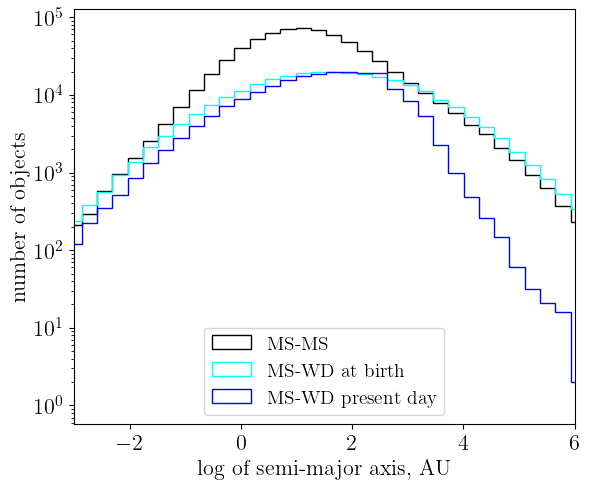

In [68]:
# let's compare initial and final SMAs
n_bins=50
fig=plt.figure()
fig.patch.set_facecolor('white')
(n,bins,patches)=plt.hist(np.log10(mybin1['sma']), n_bins, histtype='step', stacked=True, fill=False, color='black', label='MS-MS')
plt.hist(np.log10(mybin0['sma']), bins, histtype='step', stacked=True, fill=False, color='cyan', label='MS-WD at birth')
ind1=(mybin0['fsma']>0)
plt.hist(np.log10(mybin0['fsma'][ind1]), bins, histtype='step', stacked=True, fill=False, color='blue', label='MS-WD present day')
plt.legend(loc='lower center')
plt.yscale('log')
plt.xlabel('log of semi-major axis, AU')
plt.ylabel('number of objects')
plt.xlim((-3.,6.))
fig.tight_layout()
# plt.savefig('public_evolution_sma_distribution.png') # this figure is remade in public_evolution_step2
plt.show()


2.25 number of MS-WD binaries in the bin  35169 at birth  33399
2.75 number of MS-WD binaries in the bin  23860 at birth  28166
3.25 number of MS-WD binaries in the bin  11139 at birth  21093
3.75 number of MS-WD binaries in the bin  2704 at birth  13937
4.25 number of MS-WD binaries in the bin  703 at birth  8481
4.75 number of MS-WD binaries in the bin  239 at birth  4751


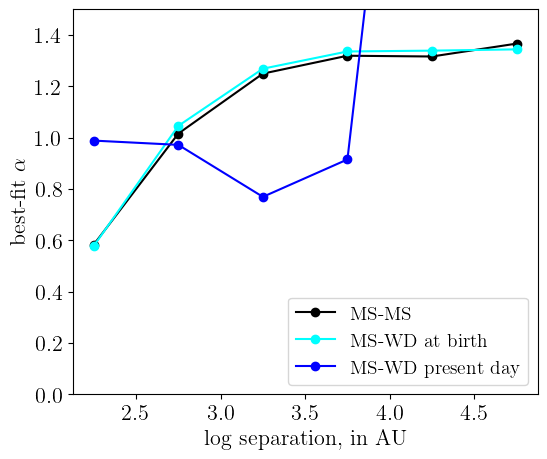

In [70]:
# let's do the eccentricity distribution! 
lg_fsma_bins=np.arange(2.25,5.25,0.5)
# set up empty arrays
alpha_msms=np.zeros(len(lg_fsma_bins))
alpha_birth=np.zeros(len(lg_fsma_bins))
alpha_wdms=np.zeros(len(lg_fsma_bins))
for i,lg_fsma in enumerate(lg_fsma_bins):
    ind1=((mybin1['sma']>=10**(lg_fsma-0.25)) & (mybin1['sma']<10**(lg_fsma+0.25)))
    birth0=((mybin0['sma']>=10**(lg_fsma-0.25)) & (mybin0['sma']<10**(lg_fsma+0.25)))
    ind0=((mybin0['fsma']>=10**(lg_fsma-0.25)) & (mybin0['fsma']<10**(lg_fsma+0.25)) & (mybin0['fecc']<1))
    alpha_msms[i]=orbital.max_likelihood_ecc(mybin1['ecc'][ind1])
    alpha_birth[i]=orbital.max_likelihood_ecc(mybin0['ecc'][birth0])
    alpha_wdms[i]=orbital.max_likelihood_ecc(mybin0['fecc'][ind0])
    print(lg_fsma, 'number of MS-WD binaries in the bin ', len(mybin0[ind0]), 'at birth ',  len(mybin0[birth0]))
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.plot(lg_fsma_bins,alpha_msms,color='black', marker='o', label='MS-MS')                                  
plt.plot(lg_fsma_bins,alpha_birth,color='cyan', marker='o', label='MS-WD at birth')                                  
plt.plot(lg_fsma_bins,alpha_wdms,color='blue', marker='o', label='MS-WD present day')                                  
plt.legend(loc='lower right')
plt.ylim((0.,1.5))
plt.xlabel('log separation, in AU')
plt.ylabel(r'best-fit $\alpha$')
#plt.savefig('public_evolution_ecc_distribution.png') # this figure is remade in public_evolution_step2
plt.show()


<h2>OK, let's examine the eccentricities at 1000-10000 AU: these eccentricities look smaller than for the MS-MS binaries of the same separation</h2>

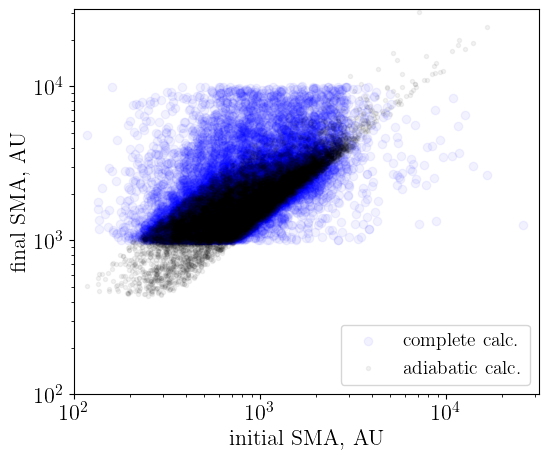

median expected factor of adiabatic expansion:  2.058854247221299
median actual expansion:  2.4040169132729297


In [96]:
# why does this happen?
ind=((mybin0['fsma']>1e3) & (mybin0['fsma']<1e4))
# where did they come from? 
fit=plt.figure()
temp=mybin0['sma']*(mybin0['m1']+mybin0['m2'])/(mybin0['fm1']+mybin0['m2'])
plt.scatter(mybin0['sma'][ind], mybin0['fsma'][ind], color='blue', alpha=0.05, label='complete calc.')
plt.scatter(mybin0['sma'][ind], temp[ind], marker='.', color='black', alpha=0.05, label='adiabatic calc.')
plt.xlim((10.**2,10.**4.5))
plt.ylim((10.**2,10.**4.5))
plt.legend(loc='lower right')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('initial SMA, AU')
plt.ylabel('final SMA, AU')
plt.show()
# what is the median expansion amount and how does this compare to the median adiabatic expansion from mass loss?
print('median expected factor of adiabatic expansion: ', 
      np.median((mybin0['m1'][ind]+mybin0['m2'][ind])/(mybin0['fm1'][ind]+mybin0['m2'][ind])))
print('median actual expansion: ', np.median(mybin0['fsma'][ind]/mybin0['sma'][ind]))

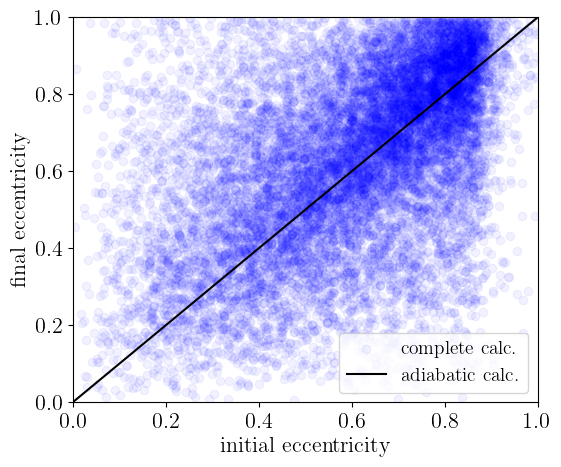

In [57]:
# so most of it is adiabatic expansion. What about eccentricities?
fit=plt.figure()
plt.scatter(mybin0['ecc'][ind], mybin0['fecc'][ind], color='blue', alpha=0.05, label='complete calc.')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), color='black', label='adiabatic calc.')
plt.xlim((0.,1.))
plt.ylim((0.,1.))
plt.legend(loc='lower right')
plt.xlabel('initial eccentricity')
plt.ylabel('final eccentricity')
plt.show()

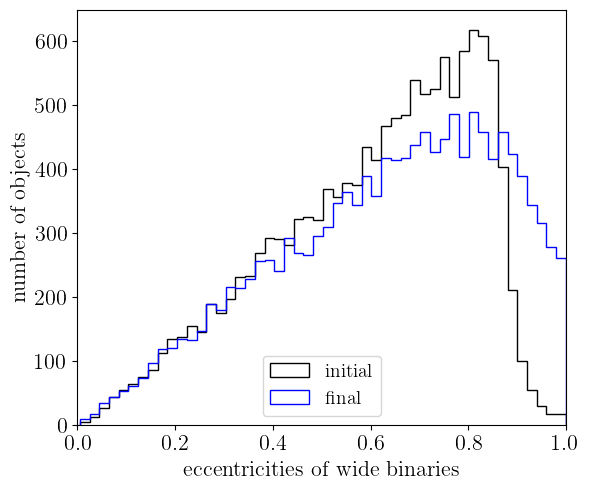

In [58]:
# what is going on with these initial eccentricities?? 
n_bins=50
fig=plt.figure()
(n,bins,patches)=plt.hist(mybin0['ecc'][ind], n_bins, histtype='step', stacked=True, fill=False, color='black', label='initial')
plt.hist(mybin0['fecc'][ind], bins, histtype='step', stacked=True, fill=False, color='blue', label='final')
plt.legend(loc='lower center')
#plt.yscale('log')
plt.xlabel('eccentricities of wide binaries')
plt.ylabel('number of objects')
plt.xlim((0.,1.))
fig.tight_layout()
plt.show()
# OK, it sounds like the most eccentric binaries are getting disrupted? So they are eliminated, and the individual 
# binaries that remain then actually become slightly eccentric! 

<h2>OK, let's examine the eccentricities at 100-1000 AU</h2>

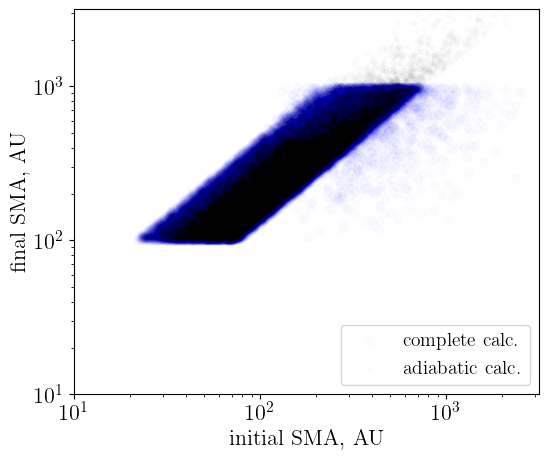

median expected factor of adiabatic expansion:  2.0731668490136035
median actual expansion:  2.0618176023297607


In [97]:
# why does this happen?
ind=((mybin0['fsma']>1e2) & (mybin0['fsma']<1e3))
# where did they come from? 
fit=plt.figure()
temp=mybin0['sma']*(mybin0['m1']+mybin0['m2'])/(mybin0['fm1']+mybin0['m2'])
plt.scatter(mybin0['sma'][ind], mybin0['fsma'][ind], color='blue', alpha=0.01, label='complete calc.')
plt.scatter(mybin0['sma'][ind], temp[ind], marker='.', color='black', alpha=0.01, label='adiabatic calc.')
plt.xlim((10.**1,10.**3.5))
plt.ylim((10.**1,10.**3.5))
plt.legend(loc='lower right')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('initial SMA, AU')
plt.ylabel('final SMA, AU')
plt.show()
# what is the median expansion amount and how does this compare to the median adiabatic expansion from mass loss?
print('median expected factor of adiabatic expansion: ', 
      np.median((mybin0['m1'][ind]+mybin0['m2'][ind])/(mybin0['fm1'][ind]+mybin0['m2'][ind])))
print('median actual expansion: ', np.median(mybin0['fsma'][ind]/mybin0['sma'][ind]))

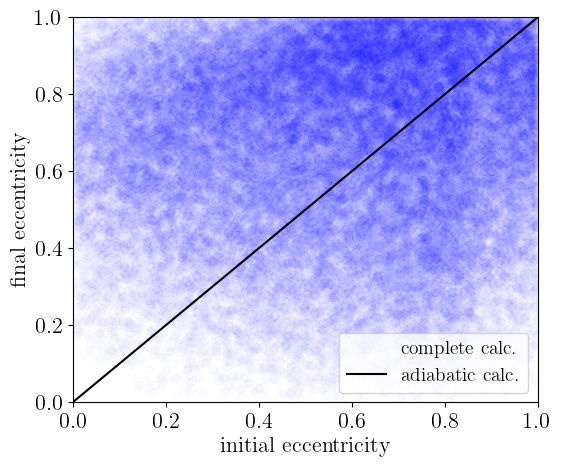

In [98]:
# so most of it is adiabatic expansion. What about eccentricities?
fit=plt.figure()
plt.scatter(mybin0['ecc'][ind], mybin0['fecc'][ind], color='blue', alpha=0.01, label='complete calc.')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), color='black', label='adiabatic calc.')
plt.xlim((0.,1.))
plt.ylim((0.,1.))
plt.legend(loc='lower right')
plt.xlabel('initial eccentricity')
plt.ylabel('final eccentricity')
plt.show()

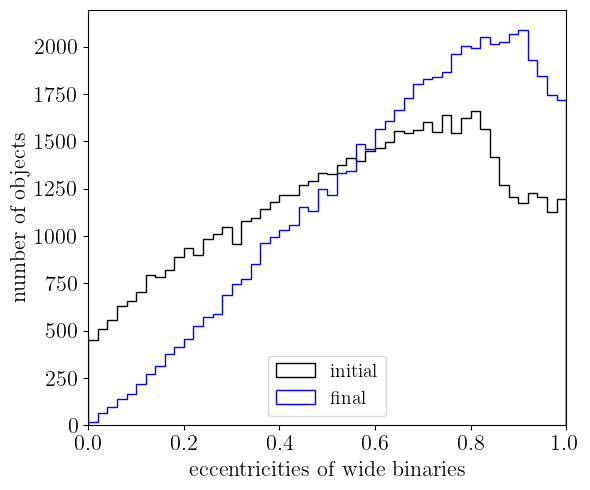

In [89]:
# what is going on with these initial eccentricities?? 
n_bins=50
fig=plt.figure()
(n,bins,patches)=plt.hist(mybin0['ecc'][ind], n_bins, histtype='step', stacked=True, fill=False, color='black', label='initial')
plt.hist(mybin0['fecc'][ind], bins, histtype='step', stacked=True, fill=False, color='blue', label='final')
plt.legend(loc='lower center')
#plt.yscale('log')
plt.xlabel('eccentricities of wide binaries')
plt.ylabel('number of objects')
plt.xlim((0.,1.))
fig.tight_layout()
plt.show()
# OK, it sounds like the most eccentric binaries are getting disrupted? So they are eliminated, and the individual 
# binaries that remain then actually become slightly eccentric! 

<h2>OK, finally eccentricities at >10000 AU</h2>

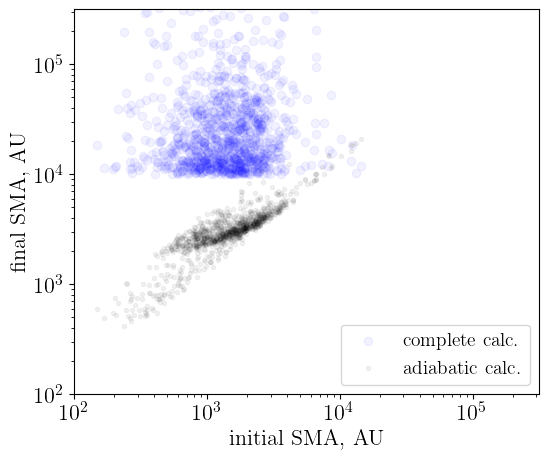

median expected factor of adiabatic expansion:  2.0105325835432537
median actual expansion:  16.308754657838673


In [101]:
# why does this happen?
ind=(mybin0['fsma']>1e4)
# where did they come from? 
fit=plt.figure()
temp=mybin0['sma']*(mybin0['m1']+mybin0['m2'])/(mybin0['fm1']+mybin0['m2'])
plt.scatter(mybin0['sma'][ind], mybin0['fsma'][ind], color='blue', alpha=0.05, label='complete calc.')
plt.scatter(mybin0['sma'][ind], temp[ind], marker='.', color='black', alpha=0.05, label='adiabatic calc.')
plt.xlim((10.**2,10.**5.5))
plt.ylim((10.**2,10.**5.5))
plt.legend(loc='lower right')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('initial SMA, AU')
plt.ylabel('final SMA, AU')
plt.show()
# what is the median expansion amount and how does this compare to the median adiabatic expansion from mass loss?
print('median expected factor of adiabatic expansion: ', 
      np.median((mybin0['m1'][ind]+mybin0['m2'][ind])/(mybin0['fm1'][ind]+mybin0['m2'][ind])))
print('median actual expansion: ', np.median(mybin0['fsma'][ind]/mybin0['sma'][ind]))

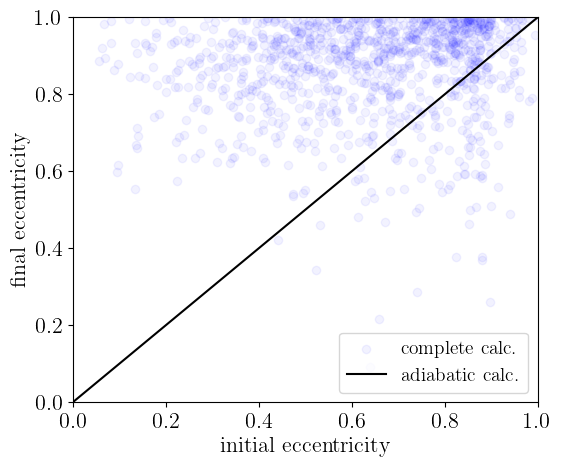

In [102]:
# What about eccentricities?
fit=plt.figure()
plt.scatter(mybin0['ecc'][ind], mybin0['fecc'][ind], color='blue', alpha=0.05, label='complete calc.')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), color='black', label='adiabatic calc.')
plt.xlim((0.,1.))
plt.ylim((0.,1.))
plt.legend(loc='lower right')
plt.xlabel('initial eccentricity')
plt.ylabel('final eccentricity')
plt.show()

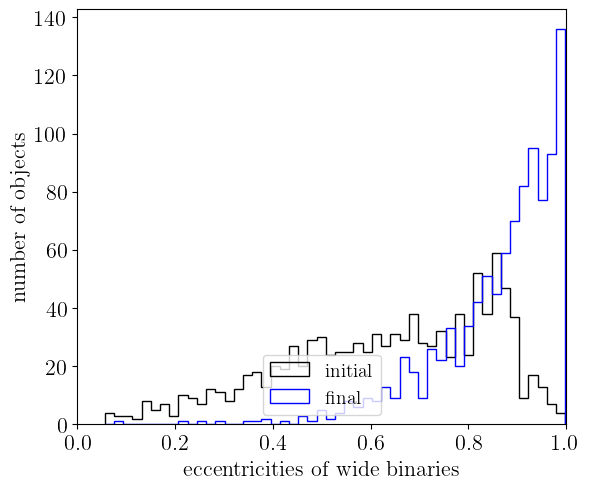

In [103]:
# what is going on with these initial eccentricities?? 
n_bins=50
fig=plt.figure()
(n,bins,patches)=plt.hist(mybin0['ecc'][ind], n_bins, histtype='step', stacked=True, fill=False, color='black', label='initial')
plt.hist(mybin0['fecc'][ind], bins, histtype='step', stacked=True, fill=False, color='blue', label='final')
plt.legend(loc='lower center')
#plt.yscale('log')
plt.xlabel('eccentricities of wide binaries')
plt.ylabel('number of objects')
plt.xlim((0.,1.))
fig.tight_layout()
plt.show()
# OK, it sounds like the most eccentric binaries are getting disrupted? So they are eliminated, and the individual 
# binaries that remain then actually become slightly eccentric! 

<h1>Now some plots for all MS-WD binaries again</h1>

In [91]:
# let's look at the statistics of the disrupted binaries:
ind=(mybin0['fsma']<0)
ind1=(mybin0['fecc']>1)
print(len(mybin0[ind]),len(mybin0[ind1]))

63380 63380


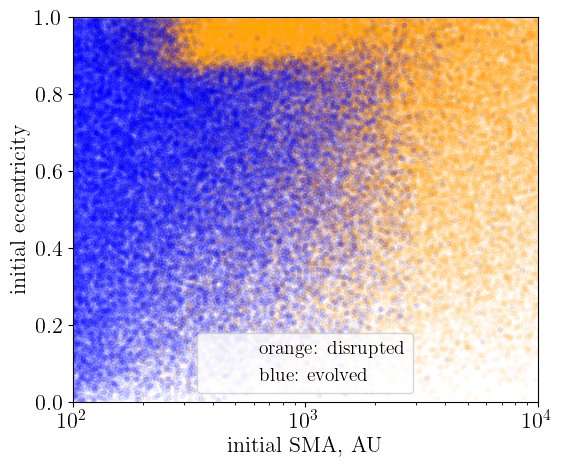

In [92]:
fig=plt.figure()
plt.scatter(mybin0['sma'][ind],mybin0['ecc'][ind],color='orange',marker='.', alpha=0.05,label='orange: disrupted')
plt.scatter(mybin0['sma'][~ind],mybin0['ecc'][~ind],color='blue',marker='.',alpha=0.05,label='blue: evolved')
plt.xlabel('initial SMA, AU')
plt.ylabel('initial eccentricity')
plt.xlim((1e2,1e4))
plt.ylim((0.,1.))
plt.xscale('log')
plt.legend(loc='lower center')
plt.show()

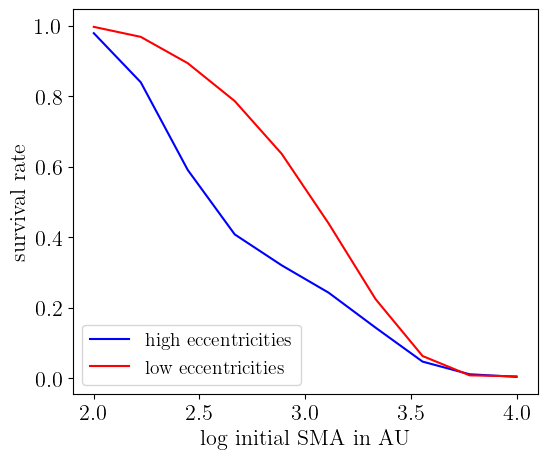

In [107]:
# what is the disruption fraction as a function of initial separation / eccentricity?
lgsma=np.linspace(2,4,num=10)
delta=lgsma[1]-lgsma[0]
survival_highe=np.zeros(len(lgsma))
survival_lowe=np.zeros(len(lgsma))
for i,lga in enumerate(lgsma):
    u1=((mybin0['sma']>=10**(lga-delta)) & (mybin0['sma']<10**(lga+delta)) & (mybin0['ecc']>0.7))
    u2=((mybin0['sma']>=10**(lga-delta)) & (mybin0['sma']<10**(lga+delta)) & (mybin0['ecc']>0.7) & (mybin0['fsma']>0))
    u3=((mybin0['sma']>=10**(lga-delta)) & (mybin0['sma']<10**(lga+delta)) & (mybin0['ecc']<0.7))
    u4=((mybin0['sma']>=10**(lga-delta)) & (mybin0['sma']<10**(lga+delta)) & (mybin0['ecc']<0.7) & (mybin0['fsma']>0))
    survival_highe[i]=len(mybin0[u2])/len(mybin0[u1])
    survival_lowe[i]=len(mybin0[u4])/len(mybin0[u3])
fig=plt.figure()
plt.plot(lgsma, survival_highe, color='blue', label='high eccentricities')        
plt.plot(lgsma, survival_lowe, color='red', label='low eccentricities')
plt.xlabel('log initial SMA in AU')
plt.ylabel('survival rate')
plt.legend(loc='lower left')
plt.show()


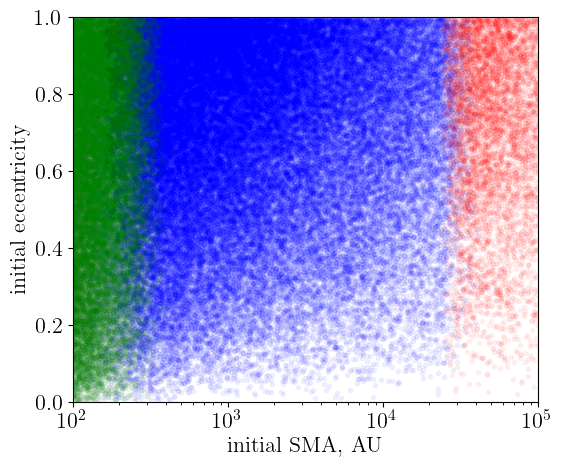

In [63]:
# one final plot to understand how the orbits were integrated
fig=plt.figure()
plt.scatter(mybin02['sma'][ind_dir],mybin02['ecc'][ind_dir],color='blue',marker='.',alpha=0.05,label='direct')
plt.scatter(mybin02['sma'][ind_ham],mybin02['ecc'][ind_ham],color='green',marker='.',alpha=0.05,label='hamiltonian')
plt.scatter(mybin02['sma'][ind_imp],mybin02['ecc'][ind_imp],color='red',marker='.',alpha=0.05,label='impulsive')
plt.xlabel('initial SMA, AU')
plt.ylabel('initial eccentricity')
plt.xlim((1e2,1e5))
plt.ylim((0.,1.))
plt.xscale('log')
plt.show()

<h3>The next step is to evolve the Class 2 objects all the way through the second stage to WD-WD, this is in public_evolution_step2, and then calculate the mass-dependent statistics, that's in public_statistics. </h3>